<a href="https://www.kaggle.com/code/ayushhood/soc-project1?scriptVersionId=261297195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/state-of-charge-and-state-of-health-of-batteries/Experimental_data_fresh_cell.csv
/kaggle/input/state-of-charge-and-state-of-health-of-batteries/SOC_SOH_simple_model.m
/kaggle/input/state-of-charge-and-state-of-health-of-batteries/Experimental_data_aged_cell.csv
/kaggle/input/state-of-charge-and-state-of-health-of-batteries/SOC_SOH_extendend_model.m
/kaggle/input/state-of-charge-and-state-of-health-of-batteries/OCV_vs_SOC_curve.csv


## *Battery Rating*
Voltage : 3.7 V nominal, 4.2 V max, 3.0 V min
Temperature : Fresh cell: ~24.8 °C → 27.1 °C , Aged cell: ~25.1 °C → 28.1 °C.


In [2]:
df_aged = pd.read_csv("/kaggle/input/state-of-charge-and-state-of-health-of-batteries/Experimental_data_aged_cell.csv")
df_aged

,Time,Current,Voltage,Temperature
0,0.000000,2.360728,2.999311,27.449894
1,1.000008,2.303036,2.999813,27.724861
2,2.000008,2.284371,2.999863,27.545357
3,3.000008,2.221588,2.999863,27.457523
4,4.000008,2.158805,2.999813,27.484249
...,...,...,...,...
307508,307508.000008,-1.097407,4.199590,25.719833
307509,307509.000000,-1.165280,4.199289,25.746559
307510,307510.000008,-1.058380,4.199289,25.677824
307511,307511.000015,-1.041411,4.199139,25.738930


In [3]:
df_fresh = pd.read_csv("/kaggle/input/state-of-charge-and-state-of-health-of-batteries/Experimental_data_fresh_cell.csv")
df_fresh

,Time,Current,Voltage,Temperature
0,0.000000,2.158704,2.999607,26.384377
1,1.000000,2.287674,2.999407,26.227879
2,2.000000,2.228280,2.999757,26.449251
3,2.999992,2.224886,2.999857,26.277494
4,4.000000,2.134946,2.999958,26.380539
...,...,...,...,...
358304,358304.000008,-1.040085,4.199367,25.128578
358305,358305.000000,-1.014630,4.199016,25.235462
358306,358306.000000,-2.076933,4.202249,25.162935
358307,358307.000000,0.510946,4.195336,25.209021


In [4]:
df_ocv = pd.read_csv("/kaggle/input/state-of-charge-and-state-of-health-of-batteries/OCV_vs_SOC_curve.csv")
df_ocv

,SOC,V0
0,0.000,3.010470
1,0.001,3.031911
2,0.002,3.049571
3,0.003,3.065900
4,0.004,3.080937
...,...,...
996,0.996,4.189790
997,0.997,4.191605
998,0.998,4.193404
999,0.999,4.195333


In [5]:
df_aged.columns

Index(['Time', 'Current', 'Voltage', 'Temperature'], dtype='object')

In [6]:
df_fresh.columns

Index(['Time', 'Current', 'Voltage', 'Temperature'], dtype='object')

In [7]:
df_ocv.columns

Index(['SOC', 'V0'], dtype='object')

In [8]:
print (df_aged.info())
print (df_fresh.info())
print (df_ocv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307513 entries, 0 to 307512
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         307513 non-null  float64
 1   Current      307513 non-null  float64
 2   Voltage      307513 non-null  float64
 3   Temperature  307513 non-null  float64
dtypes: float64(4)
memory usage: 9.4 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358309 entries, 0 to 358308
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         358309 non-null  float64
 1   Current      358309 non-null  float64
 2   Voltage      358309 non-null  float64
 3   Temperature  358309 non-null  float64
dtypes: float64(4)
memory usage: 10.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -

In [9]:
# Aged Cells 
print(df_aged.describe());

                Time        Current        Voltage    Temperature
count  307513.000000  307513.000000  307513.000000  307513.000000
mean   153756.000008      -0.163968       3.849060      26.320183
std     88771.501002      17.285349       0.206192       0.433726
min         0.000000     -20.152779       2.998059      25.112604
25%     76878.000008     -19.996674       3.726224      25.941347
50%    153756.000008      -4.350225       3.858586      26.372910
75%    230634.000008      19.973799       3.996411      26.640247
max    307512.000008      33.203965       4.208818      28.110600


### Aged Battery Cell
Time 
* Runs from 0 → ~ 307,513 s (~85 hours) → dataset spans multiple charge/discharge cycles.

Current (A)
* Range: –20.15 A (discharge) → +33.2 A (charge).
* Mean current ≈ –0.16 A → dataset is balanced between charging/discharging.

Voltage (V)
* Range: 2.998 V → 4.209 V.
* Matches a single Li-ion cell (3.84 V nominal, 4.2 V max, ~3.0 V min).
* Mean voltage = 3.85 V, so dataset is mostly around mid-to-high SOC.

Temperature (°C)
* Range: 25.1 → 28.1 °C, mean ~26.3 °C.

In [10]:
print(df_fresh.describe());

                Time        Current        Voltage    Temperature
count  358309.000000  358309.000000  358309.000000  358309.000000
mean   179154.000000      -0.142882       3.816629      25.715882
std    103435.043139      17.736151       0.203309       0.327616
min         0.000000     -20.105541       2.998705      24.776148
25%     89577.000000     -19.951117       3.704146      25.491190
50%    179153.999992      -4.340691       3.820156      25.727844
75%    268730.999992      20.037979       3.956430      25.964499
max    358308.000000      32.476771       4.204252      27.113413


### New Battery Cell
Time 
* Runs from 0 → ~ 358309.0s (~99 hours) → dataset spans multiple charge/discharge cycles.

Current (A)
* Range: –20.1 A (discharge) → +32.4 A (charge).
* Mean current ≈ –0.14 A → dataset is balanced between charging/discharging.

Voltage (V)
* Range: 2.998 V → 4.2 V.
* Matches a single Li-ion cell (3.81 V nominal, 4.2 V max, ~3.0 V min).
* Mean voltage = 3.81 V, so dataset is mostly around mid-to-high SOC.

Temperature (°C)
* Range: 24.77 → 27.1 °C, mean 25.7 °C.

In [11]:
df_ocv.describe()

,SOC,V0
count,1001.000000,1001.000000
mean,0.500000,3.776021
std,0.289108,0.236200
min,0.000000,3.010470
25%,0.250000,3.604114
50%,0.500000,3.777094
75%,0.750000,3.979707
max,1.000000,4.197726


In [12]:
df_aged.isnull().sum()

Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64

In [13]:
df_fresh.isnull().sum()

Time           0
Current        0
Voltage        0
Temperature    0
dtype: int64

In [14]:
df_ocv.isnull().sum()

SOC    0
V0     0
dtype: int64

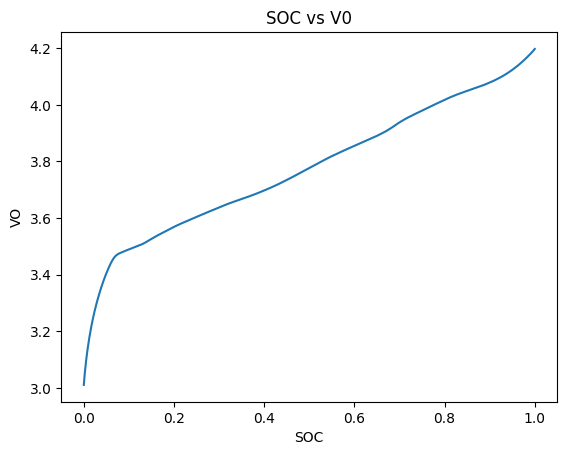

In [15]:
plt.plot(df_ocv['SOC'],df_ocv['V0'])
plt.title("SOC vs V0")
plt.xlabel("SOC")
plt.ylabel("VO")
plt.show()

### Feature Scaling

In [16]:
def compute_capacity(df):
    # Ensure sorted by time
    df = df.sort_values("Time").reset_index(drop=True)

    # Time difference in seconds
    dt = np.diff(df["Time"].values,prepend=df["Time"].values[0])

    # Charge in Ampere-seconds (Coulombs)
    charge_coulombs = np.sum(df["Current"].values * dt)

    # Convert to Ah
    capacity_ah = abs(charge_coulombs)/ 3600.0
    return capacity_ah


In [17]:
aged_capacity = compute_capacity(df_aged) 
fresh_capacity = compute_capacity(df_fresh)
print("Aged Capacity: " + str(aged_capacity) + " Ah")
print("Fresh Capacity: " + str(fresh_capacity) + " Ah")
# Aged battery retains about 98.5% of the fresh battery's capacity

Aged Capacity: 14.006881059450592 Ah
Fresh Capacity: 14.22165385040457 Ah


In [18]:
ocv_to_soc = interp1d(df_ocv["V0"], df_ocv["SOC"],bounds_error=False, fill_value="extrapolate")
ocv_to_soc

In [19]:
def compute_soc(df, capacity_ah):
    df = df.sort_values("Time").reset_index(drop=True)
    dt = np.diff(df["Time"].values, prepend=df["Time"].values[0])
    soc = [1.0]
    for i in range(1, len(df)):
        delta_q = (df["Current"].iloc[i] * dt[i]) / 3600.0
        soc.append(soc[-1] - delta_q / capacity_ah)
        # OCV correction at rest
        if abs(df["Current"].iloc[i]) < 0.05:
            soc_est = ocv_to_soc(df["Voltage"].iloc[i])
            soc[-1] = 0.9*soc[-1] + 0.1*soc_est
    return np.clip(soc, 0, 1)

In [20]:
df_fresh["SOC_true"] = compute_soc(df_fresh, fresh_capacity)
df_aged["SOC_true"]  = compute_soc(df_aged, fresh_capacity)

In [21]:
df_fresh

,Time,Current,Voltage,Temperature,SOC_true
0,0.000000,2.158704,2.999607,26.384377,1.000000
1,1.000000,2.287674,2.999407,26.227879,0.999955
2,2.000000,2.228280,2.999757,26.449251,0.999912
3,2.999992,2.224886,2.999857,26.277494,0.999868
4,4.000000,2.134946,2.999958,26.380539,0.999827
...,...,...,...,...,...
358304,358304.000008,-1.040085,4.199367,25.128578,1.000000
358305,358305.000000,-1.014630,4.199016,25.235462,1.000000
358306,358306.000000,-2.076933,4.202249,25.162935,1.000000
358307,358307.000000,0.510946,4.195336,25.209021,1.000000


In [22]:
def build_features(df):
    df_feat = df[["Current", "Voltage", "Temperature"]].copy()
    df_feat["cum_charge"] = np.cumsum(df["Current"].values * np.gradient(df["Time"].values)) / 3600.0
    return df_feat

In [23]:
X_train = build_features(df_fresh)
y_train = df_fresh["SOC_true"]

X_test = build_features(df_aged)
y_test = df_aged["SOC_true"]

### ML MODEL : Random Forest Regressor

In [24]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=42)

In [25]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest SOC Estimator Results:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Random Forest SOC Estimator Results:
MAE: 0.1011
RMSE: 0.1824
R²: 0.4276


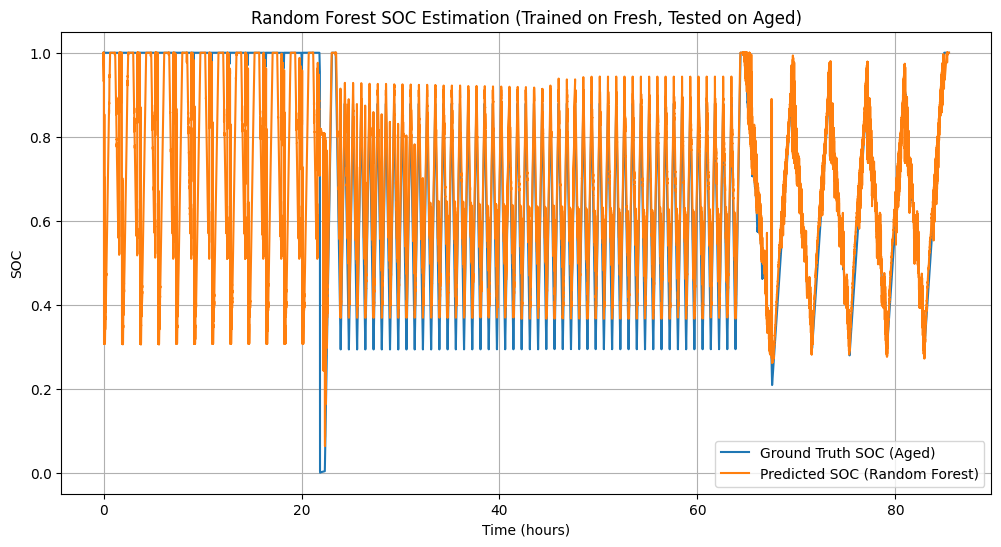

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df_aged["Time"]/3600, y_test, label="Ground Truth SOC (Aged)")
plt.plot(df_aged["Time"]/3600, y_pred, label="Predicted SOC (Random Forest)")
plt.xlabel("Time (hours)")
plt.ylabel("SOC")
plt.title("Random Forest SOC Estimation (Trained on Fresh, Tested on Aged)")
plt.legend()
plt.grid(True)
plt.show()

### XG Boost

In [27]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [28]:
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)

print(f"\nXG Boost SOC Estimator Results:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


XG Boost SOC Estimator Results:
MAE:  0.1015
RMSE: 0.1712
R²:   0.4957


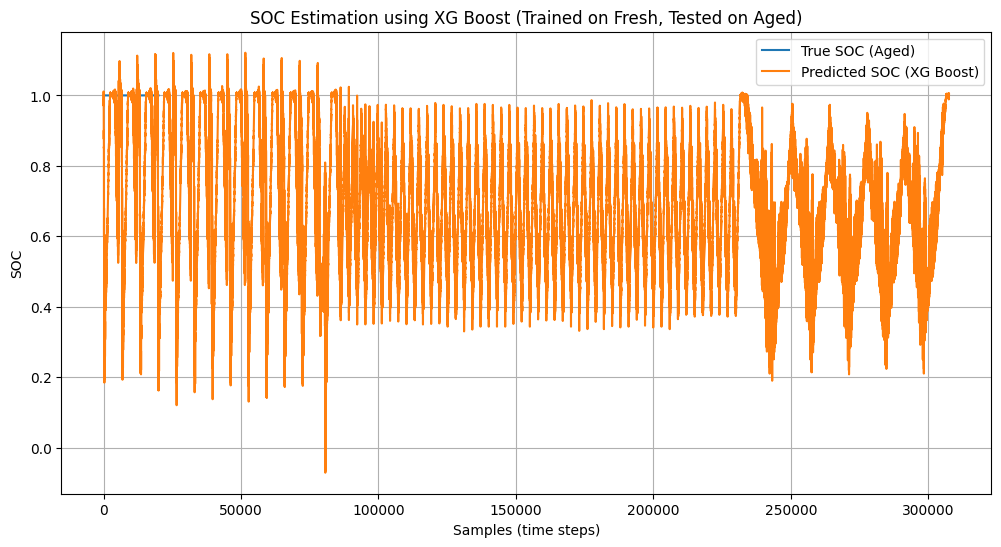

In [29]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:20000], label="True SOC (Aged)")
plt.plot(y_pred_xgb, label="Predicted SOC (XG Boost)")
plt.xlabel("Samples (time steps)")
plt.ylabel("SOC")
plt.title("SOC Estimation using XG Boost (Trained on Fresh, Tested on Aged)")
plt.legend()
plt.grid(True)
plt.show()

### SVM 

In [30]:
from sklearn.svm import SVR
svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

# Train on first 10k samples of fresh dataset
svm.fit(X_train[:10000], y_train[:10000])

# Predict on first 20k samples of aged dataset
y_pred = svm.predict(X_test[:20000])

In [31]:
mae = mean_absolute_error(y_test[:20000], y_pred)
rmse = np.sqrt(mean_squared_error(y_test[:20000], y_pred))
r2 = r2_score(y_test[:20000], y_pred)

print(f"\nSVM SOC Estimator Results:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


SVM SOC Estimator Results:
MAE:  0.0046
RMSE: 0.0046
R²:   -47.6186


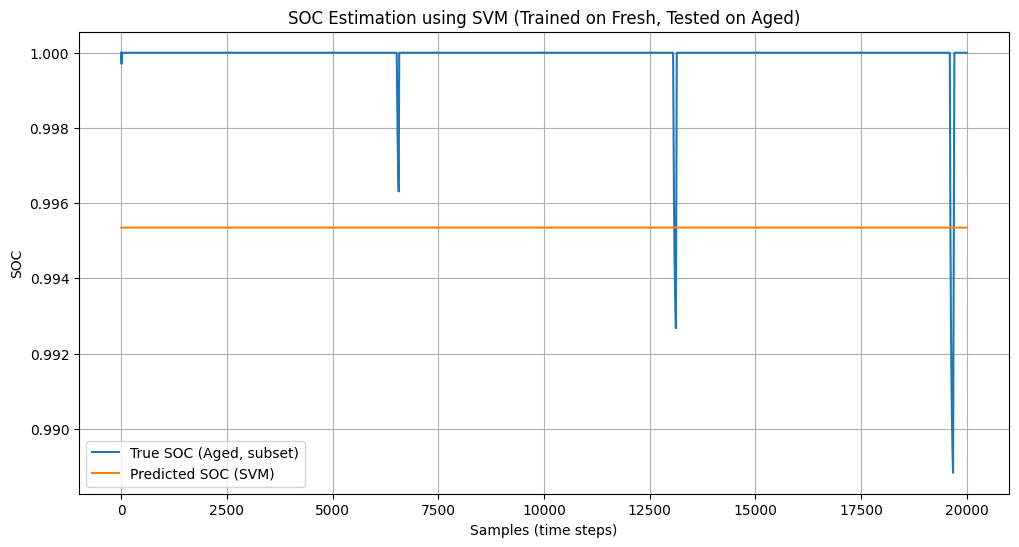

In [32]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:20000], label="True SOC (Aged, subset)")
plt.plot(y_pred, label="Predicted SOC (SVM)")
plt.xlabel("Samples (time steps)")
plt.ylabel("SOC")
plt.title("SOC Estimation using SVM (Trained on Fresh, Tested on Aged)")
plt.legend()
plt.grid(True)
plt.show()